<a href="https://colab.research.google.com/github/DennisWayo/Q-DFTNet/blob/main/Q_DFTNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Q-DFTNet Framework for Predicting Molecular Dipole Moments

In [ ]:
!pip install torch torchvision torchaudio
!pip install torch-scatter torch-sparse torch-geometric -f https://data.pyg.org/whl/torch-2.0.0+cpu.html

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [ ]:
# 1. Install PyTorch Geometric dependencies if not already installed
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install torch-geometric

Looking in indexes: https://download.pytorch.org/whl/cpu
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html


In [ ]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import os
import pandas as pd
import json

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 32
epochs = 100
target_index = 0  # μ (dipole moment)

os.makedirs("results", exist_ok=True)

path = './qm9'
dataset = QM9(path)
dataset = dataset.shuffle()

# Normalize target
mean = dataset.data.y[:, target_index].mean().item()
std = dataset.data.y[:, target_index].std().item()

def normalize(t): return (t - mean) / std
def denormalize(t): return t * std + mean

# Split
train_dataset = dataset[:10000]
val_dataset = dataset[10000:11000]
test_dataset = dataset[11000:12000]

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

from torch_geometric.nn import GCNConv, GINConv, GATConv, GraphConv, SAGEConv, EdgeConv, global_mean_pool
from torch.nn import Linear, Sequential, ReLU
import torch.nn.functional as F

def get_model(model_name, in_dim):
    import torch.nn.functional as F
    from torch.nn import Linear, Sequential, ReLU
    from torch_geometric.nn import GCNConv, GINConv, GATConv, GraphConv, SAGEConv, EdgeConv, global_mean_pool

    class BaseModel(torch.nn.Module):
        def forward_common(self, x, edge_index, batch):
            raise NotImplementedError

        def forward(self, x, edge_index, batch, return_latent=False):
            x = self.forward_common(x, edge_index, batch)
            x = F.relu(self.lin1(x))
            if return_latent:
                return x
            return self.lin2(x)

    if model_name == "GCN":
        class Net(BaseModel):
            def __init__(self):
                super().__init__()
                self.conv1 = GCNConv(in_dim, 64)
                self.conv2 = GCNConv(64, 64)
                self.lin1 = Linear(64, 32)
                self.lin2 = Linear(32, 1)

            def forward_common(self, x, edge_index, batch):
                x = F.relu(self.conv1(x, edge_index))
                x = F.relu(self.conv2(x, edge_index))
                return global_mean_pool(x, batch)
        return Net()

    if model_name == "GIN":
        class Net(BaseModel):
            def __init__(self):
                super().__init__()
                self.conv1 = GINConv(Sequential(Linear(in_dim, 64), ReLU(), Linear(64, 64)))
                self.conv2 = GINConv(Sequential(Linear(64, 64), ReLU(), Linear(64, 64)))
                self.lin1 = Linear(64, 32)
                self.lin2 = Linear(32, 1)

            def forward_common(self, x, edge_index, batch):
                x = F.relu(self.conv1(x, edge_index))
                x = F.relu(self.conv2(x, edge_index))
                return global_mean_pool(x, batch)
        return Net()

    if model_name == "GATNet" or model_name == "GATConv":
        class Net(BaseModel):
            def __init__(self):
                super().__init__()
                self.conv1 = GATConv(in_dim, 64, heads=1)
                self.conv2 = GATConv(64, 64, heads=1)
                self.lin1 = Linear(64, 32)
                self.lin2 = Linear(32, 1)

            def forward_common(self, x, edge_index, batch):
                x = F.elu(self.conv1(x, edge_index))
                x = F.elu(self.conv2(x, edge_index))
                return global_mean_pool(x, batch)
        return Net()

    if model_name == "SAGEConv":
        class Net(BaseModel):
            def __init__(self):
                super().__init__()
                self.conv1 = SAGEConv(in_dim, 64)
                self.conv2 = SAGEConv(64, 64)
                self.lin1 = Linear(64, 32)
                self.lin2 = Linear(32, 1)

            def forward_common(self, x, edge_index, batch):
                x = F.relu(self.conv1(x, edge_index))
                x = F.relu(self.conv2(x, edge_index))
                return global_mean_pool(x, batch)
        return Net()

    if model_name == "GraphConv":
        class Net(BaseModel):
            def __init__(self):
                super().__init__()
                self.conv1 = GraphConv(in_dim, 64)
                self.conv2 = GraphConv(64, 64)
                self.lin1 = Linear(64, 32)
                self.lin2 = Linear(32, 1)

            def forward_common(self, x, edge_index, batch):
                x = F.relu(self.conv1(x, edge_index))
                x = F.relu(self.conv2(x, edge_index))
                return global_mean_pool(x, batch)
        return Net()

    if model_name == "GIN+EdgeConv":
        class Net(BaseModel):
            def __init__(self):
                super().__init__()
                self.conv1 = GINConv(Sequential(Linear(in_dim, 64), ReLU(), Linear(64, 64)))
                self.conv2 = EdgeConv(Sequential(Linear(2 * 64, 64), ReLU(), Linear(64, 64)))
                self.lin1 = Linear(64, 32)
                self.lin2 = Linear(32, 1)

            def forward_common(self, x, edge_index, batch):
                x = F.relu(self.conv1(x, edge_index))
                x = F.relu(self.conv2(x, edge_index))
                return global_mean_pool(x, batch)
        return Net()

    raise ValueError(f"Unknown model: {model_name}")


def train_one_epoch(model, loader, optimizer, loss_fn):
    model.train()
    total_loss = 0
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        y = normalize(batch.y[:, target_index]).unsqueeze(1)
        pred = model(batch.x, batch.edge_index, batch.batch)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs
    return total_loss / len(loader.dataset)

def evaluate(model, loader):
    model.eval()
    total_loss = 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            y = normalize(batch.y[:, target_index]).unsqueeze(1)
            pred = model(batch.x, batch.edge_index, batch.batch)
            total_loss += F.mse_loss(pred, y, reduction='sum').item()
            y_true.append(batch.y[:, target_index].unsqueeze(1).cpu())  # unnormalized
            y_pred.append((pred.cpu() * std + mean))  # de-normalized

    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return mse, mae, r2, y_true, y_pred

models_to_run = ["GCN", "GIN", "GraphConv", "GATNet", "GATConv", "SAGEConv", "GIN+EdgeConv"]
loss_fn = torch.nn.MSELoss()

for model_name in models_to_run:
    print(f"\n🚀 Training {model_name}")
    model = get_model(model_name, dataset.num_node_features).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
    train_losses, val_losses, test_losses = [], [], []

    for epoch in range(1, epochs + 1):
        train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn)
        val_mse, val_mae, val_r2, _, _ = evaluate(model, val_loader)
        test_mse, _, _, _, _ = evaluate(model, test_loader)

        train_losses.append(train_loss)
        val_losses.append(val_mse)
        test_losses.append(test_mse)

        print(f"Epoch {epoch:03d} | Train: {train_loss:.4f} | Val MSE: {val_mse:.4f} | Test MSE: {test_mse:.4f}")


    # Final test evaluation
    test_mse, test_mae, test_r2, y_true, y_pred = evaluate(model, test_loader)
    print(f" {model_name} | Test MSE: {test_mse:.4f} | MAE: {test_mae:.4f} | R²: {test_r2:.4f}")

    # Save metrics
    results = {
        "Model": model_name,
        "Test_MSE": round(test_mse, 6),
        "Test_MAE": round(test_mae, 6),
        "Test_R2": round(test_r2, 6)
    }

    # Append to CSV/JSON
    csv_path = "results/model_results.csv"
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        df = df[df["Model"] != model_name]
        df = pd.concat([df, pd.DataFrame([results])], ignore_index=True)
    else:
        df = pd.DataFrame([results])
    df.to_csv(csv_path, index=False)

    json_path = "results/model_results.json"
    if os.path.exists(json_path):
        with open(json_path, "r") as f:
            data = json.load(f)
        data = [d for d in data if d["Model"] != model_name]
        data.append(results)
    else:
        data = [results]
    with open(json_path, "w") as f:
        json.dump(data, f, indent=4)

    # Save predictions and loss curves
    np.save(f"results/{model_name}_y_true.npy", y_true)
    np.save(f"results/{model_name}_y_pred.npy", y_pred)
    np.save(f"results/{model_name}_mean_std.npy", np.array([mean, std]))
    np.save(f"results/{model_name}_train_loss.npy", np.array(train_losses))
    np.save(f"results/{model_name}_val_loss.npy", np.array(val_losses))
    np.save(f"results/{model_name}_test_loss.npy", np.array(test_losses))

    # =====================================
    # Save latent graph embeddings
    # =====================================
    model.eval()
    h_latent = []
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            try:
                h = model(batch.x, batch.edge_index, batch.batch, return_latent=True)
            except TypeError:
                print(f"⚠️ {model_name} does not support return_latent=True — skipping.")
                continue
            h_latent.append(h.cpu())

    latent_array = torch.cat(h_latent).numpy()
    np.save(f"results/{model_name}_latent.npy", latent_array)
    print(f"Latent features saved to: results/{model_name}_latent.npy")

/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_sparse/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "
Extracting qm9/raw/qm9_v3.zip
Processing...
Using a pre-processed version of the dataset. Please install 'rdkit' to alternatively process the raw data.
Done!
/usr/local/lib/python3.11/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to dir


🚀 Training GCN
Epoch 001 | Train: 0.8030 | Val MSE: 1.7173 | Test MSE: 1.8103
Epoch 002 | Train: 0.6634 | Val MSE: 1.5098 | Test MSE: 1.6759
Epoch 003 | Train: 0.6203 | Val MSE: 1.3823 | Test MSE: 1.5813
Epoch 004 | Train: 0.5825 | Val MSE: 1.3331 | Test MSE: 1.5592
Epoch 005 | Train: 0.5664 | Val MSE: 1.3523 | Test MSE: 1.5367
Epoch 006 | Train: 0.5510 | Val MSE: 1.3190 | Test MSE: 1.5395
Epoch 007 | Train: 0.5413 | Val MSE: 1.2574 | Test MSE: 1.4302
Epoch 008 | Train: 0.5305 | Val MSE: 1.2466 | Test MSE: 1.4276
Epoch 009 | Train: 0.5257 | Val MSE: 1.3307 | Test MSE: 1.4555
Epoch 010 | Train: 0.5168 | Val MSE: 1.2379 | Test MSE: 1.3551
Epoch 011 | Train: 0.5188 | Val MSE: 1.2176 | Test MSE: 1.3678
Epoch 012 | Train: 0.5095 | Val MSE: 1.1975 | Test MSE: 1.3123
Epoch 013 | Train: 0.5071 | Val MSE: 1.1860 | Test MSE: 1.3066
Epoch 014 | Train: 0.5054 | Val MSE: 1.1951 | Test MSE: 1.3019
Epoch 015 | Train: 0.5028 | Val MSE: 1.2271 | Test MSE: 1.2982
Epoch 016 | Train: 0.5029 | Val MSE: 1.

/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 001 | Train: 0.7928 | Val MSE: 1.5344 | Test MSE: 1.7161


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 002 | Train: 0.6342 | Val MSE: 1.3782 | Test MSE: 1.5747


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 003 | Train: 0.5920 | Val MSE: 1.3354 | Test MSE: 1.5148


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 004 | Train: 0.5667 | Val MSE: 1.2788 | Test MSE: 1.4351


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 005 | Train: 0.5452 | Val MSE: 1.2156 | Test MSE: 1.3950


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 006 | Train: 0.5345 | Val MSE: 1.2462 | Test MSE: 1.4195


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 007 | Train: 0.5170 | Val MSE: 1.1246 | Test MSE: 1.3279


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 008 | Train: 0.5100 | Val MSE: 1.2378 | Test MSE: 1.4323


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 009 | Train: 0.4961 | Val MSE: 1.1312 | Test MSE: 1.2808


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 010 | Train: 0.4924 | Val MSE: 1.1057 | Test MSE: 1.2837


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 011 | Train: 0.4777 | Val MSE: 1.1278 | Test MSE: 1.2934


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 012 | Train: 0.4728 | Val MSE: 1.0799 | Test MSE: 1.2354


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 013 | Train: 0.4667 | Val MSE: 1.0321 | Test MSE: 1.1714


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 014 | Train: 0.4641 | Val MSE: 1.0126 | Test MSE: 1.1390


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 015 | Train: 0.4587 | Val MSE: 1.0875 | Test MSE: 1.2318


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 016 | Train: 0.4560 | Val MSE: 1.0194 | Test MSE: 1.1596


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 017 | Train: 0.4400 | Val MSE: 0.9851 | Test MSE: 1.0983


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 018 | Train: 0.4362 | Val MSE: 0.9360 | Test MSE: 1.0648


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 019 | Train: 0.4251 | Val MSE: 0.9944 | Test MSE: 1.1216


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 020 | Train: 0.4138 | Val MSE: 0.9283 | Test MSE: 1.0530


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 021 | Train: 0.4058 | Val MSE: 1.1001 | Test MSE: 1.1535


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 022 | Train: 0.3949 | Val MSE: 0.8775 | Test MSE: 0.9874


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 023 | Train: 0.3900 | Val MSE: 0.9807 | Test MSE: 1.0404


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 024 | Train: 0.3955 | Val MSE: 0.8716 | Test MSE: 0.9657


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 025 | Train: 0.3770 | Val MSE: 0.8808 | Test MSE: 1.0053


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 026 | Train: 0.3747 | Val MSE: 0.8549 | Test MSE: 0.9321


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 027 | Train: 0.3625 | Val MSE: 0.9114 | Test MSE: 0.9467


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 028 | Train: 0.3677 | Val MSE: 0.8877 | Test MSE: 0.9707


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 029 | Train: 0.3608 | Val MSE: 0.9012 | Test MSE: 0.9040


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 030 | Train: 0.3616 | Val MSE: 0.9378 | Test MSE: 0.9721


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 031 | Train: 0.3546 | Val MSE: 0.8859 | Test MSE: 0.8674


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 032 | Train: 0.3506 | Val MSE: 0.8893 | Test MSE: 0.9193


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 033 | Train: 0.3504 | Val MSE: 0.8549 | Test MSE: 0.9029


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 034 | Train: 0.3428 | Val MSE: 0.9182 | Test MSE: 0.9593


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 035 | Train: 0.3401 | Val MSE: 0.8594 | Test MSE: 0.8710


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 036 | Train: 0.3350 | Val MSE: 0.9074 | Test MSE: 0.9479


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 037 | Train: 0.3334 | Val MSE: 0.8404 | Test MSE: 0.8474


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 038 | Train: 0.3339 | Val MSE: 0.8453 | Test MSE: 0.8493


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 039 | Train: 0.3310 | Val MSE: 0.8484 | Test MSE: 0.8809


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 040 | Train: 0.3306 | Val MSE: 0.8662 | Test MSE: 0.8484


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 041 | Train: 0.3260 | Val MSE: 0.8871 | Test MSE: 0.8484


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 042 | Train: 0.3223 | Val MSE: 0.8281 | Test MSE: 0.8243


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 043 | Train: 0.3182 | Val MSE: 0.8455 | Test MSE: 0.8950


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 044 | Train: 0.3215 | Val MSE: 0.8439 | Test MSE: 0.8578


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 045 | Train: 0.3139 | Val MSE: 0.8166 | Test MSE: 0.8459


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 046 | Train: 0.3205 | Val MSE: 0.8199 | Test MSE: 0.8087


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 047 | Train: 0.3103 | Val MSE: 0.8070 | Test MSE: 0.8238


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 048 | Train: 0.3053 | Val MSE: 0.8383 | Test MSE: 0.8239


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 049 | Train: 0.3078 | Val MSE: 0.7691 | Test MSE: 0.8104


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 050 | Train: 0.3053 | Val MSE: 0.8190 | Test MSE: 0.8178


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 051 | Train: 0.3009 | Val MSE: 0.8061 | Test MSE: 0.7716


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 052 | Train: 0.3022 | Val MSE: 0.8045 | Test MSE: 0.7818


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 053 | Train: 0.3029 | Val MSE: 0.8048 | Test MSE: 0.8145


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 054 | Train: 0.3059 | Val MSE: 0.8177 | Test MSE: 0.8070


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 055 | Train: 0.2981 | Val MSE: 0.7938 | Test MSE: 0.7816


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 056 | Train: 0.2948 | Val MSE: 0.8902 | Test MSE: 0.8662


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 057 | Train: 0.2962 | Val MSE: 0.8185 | Test MSE: 0.7876


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 058 | Train: 0.2938 | Val MSE: 0.7960 | Test MSE: 0.7751


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 059 | Train: 0.2903 | Val MSE: 0.7882 | Test MSE: 0.8110


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 060 | Train: 0.2884 | Val MSE: 0.9019 | Test MSE: 0.8285


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 061 | Train: 0.2849 | Val MSE: 0.7723 | Test MSE: 0.8107


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 062 | Train: 0.2865 | Val MSE: 0.8027 | Test MSE: 0.7920


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 063 | Train: 0.2857 | Val MSE: 0.7968 | Test MSE: 0.8097


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 064 | Train: 0.2852 | Val MSE: 0.8365 | Test MSE: 0.7770


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 065 | Train: 0.2859 | Val MSE: 0.7728 | Test MSE: 0.7915


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 066 | Train: 0.2804 | Val MSE: 0.8245 | Test MSE: 0.8301


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 067 | Train: 0.2803 | Val MSE: 0.7962 | Test MSE: 0.8178


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 068 | Train: 0.2763 | Val MSE: 0.7942 | Test MSE: 0.7837


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 069 | Train: 0.2717 | Val MSE: 0.8117 | Test MSE: 0.7768


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 070 | Train: 0.2726 | Val MSE: 0.9403 | Test MSE: 0.9328


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 071 | Train: 0.2757 | Val MSE: 0.8071 | Test MSE: 0.8019


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 072 | Train: 0.2771 | Val MSE: 0.8340 | Test MSE: 0.8585


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 073 | Train: 0.2767 | Val MSE: 0.7850 | Test MSE: 0.7955


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 074 | Train: 0.2683 | Val MSE: 0.7783 | Test MSE: 0.7634


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 075 | Train: 0.2711 | Val MSE: 0.8110 | Test MSE: 0.7880


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 076 | Train: 0.2686 | Val MSE: 0.7944 | Test MSE: 0.8082


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 077 | Train: 0.2697 | Val MSE: 0.8419 | Test MSE: 0.8503


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 078 | Train: 0.2631 | Val MSE: 0.8226 | Test MSE: 0.7893


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 079 | Train: 0.2642 | Val MSE: 0.7703 | Test MSE: 0.7481


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 080 | Train: 0.2665 | Val MSE: 0.8140 | Test MSE: 0.7970


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 081 | Train: 0.2623 | Val MSE: 0.8626 | Test MSE: 0.7990


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 082 | Train: 0.2615 | Val MSE: 0.8049 | Test MSE: 0.7905


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 083 | Train: 0.2644 | Val MSE: 0.8282 | Test MSE: 0.8315


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 084 | Train: 0.2620 | Val MSE: 0.7689 | Test MSE: 0.7830


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 085 | Train: 0.2591 | Val MSE: 0.8026 | Test MSE: 0.8187


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 086 | Train: 0.2586 | Val MSE: 0.8421 | Test MSE: 0.8085


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 087 | Train: 0.2625 | Val MSE: 0.8089 | Test MSE: 0.8179


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 088 | Train: 0.2573 | Val MSE: 0.8556 | Test MSE: 0.8075


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 089 | Train: 0.2553 | Val MSE: 0.8024 | Test MSE: 0.8174


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 090 | Train: 0.2523 | Val MSE: 0.7964 | Test MSE: 0.7854


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 091 | Train: 0.2527 | Val MSE: 0.8019 | Test MSE: 0.7985


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 092 | Train: 0.2492 | Val MSE: 0.8264 | Test MSE: 0.8134


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 093 | Train: 0.2487 | Val MSE: 0.7936 | Test MSE: 0.7976


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 094 | Train: 0.2521 | Val MSE: 0.8147 | Test MSE: 0.8108


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 095 | Train: 0.2500 | Val MSE: 0.8409 | Test MSE: 0.7526


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 096 | Train: 0.2442 | Val MSE: 0.8369 | Test MSE: 0.8043


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 097 | Train: 0.2485 | Val MSE: 0.7924 | Test MSE: 0.8034


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 098 | Train: 0.2484 | Val MSE: 0.8345 | Test MSE: 0.8016


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 099 | Train: 0.2459 | Val MSE: 0.8015 | Test MSE: 0.7557


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 100 | Train: 0.2433 | Val MSE: 0.8324 | Test MSE: 0.7838
 GIN+EdgeConv | Test MSE: 0.7838 | MAE: 0.6509 | R²: 0.6687
Latent features saved to: results/GIN+EdgeConv_latent.npy


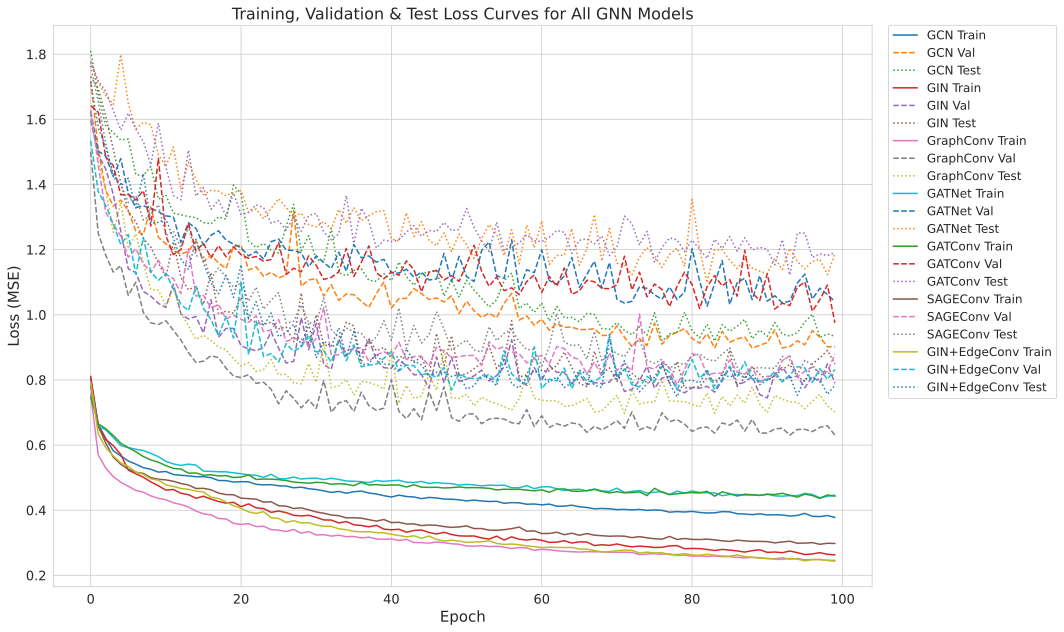

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')
sns.set_style("whitegrid")

# Font settings
plt.rcParams.update({
    'font.size': 14,           # Base font size
    'axes.titlesize': 16,      # Title
    'axes.labelsize': 15,      # X/Y labels
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 12,
    'figure.titlesize': 17
})

models = ["GCN", "GIN", "GraphConv", "GATNet", "GATConv", "SAGEConv", "GIN+EdgeConv"]
plt.figure(figsize=(15, 9))

for model in models:
    try:
        train_loss = np.load(f"results/{model}_train_loss.npy")
        val_loss = np.load(f"results/{model}_val_loss.npy")
        test_loss = np.load(f"results/{model}_test_loss.npy")

        plt.plot(train_loss, label=f"{model} Train", linestyle='-')
        plt.plot(val_loss, label=f"{model} Val", linestyle='--')
        plt.plot(test_loss, label=f"{model} Test", linestyle=':')

    except FileNotFoundError:
        print(f"⚠️ Missing logs for {model}")
        continue

plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training, Validation & Test Loss Curves for All GNN Models")

# Adjust legend
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.grid(True)

# Save high-resolution image
plt.savefig("results/loss_curves_all.png", dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error

model_names = ["GCN", "GIN", "GraphConv", "GATNet", "GATConv", "SAGEConv", "GIN+EdgeConv"]

results = []

for model in model_names:
    print(f"🔍 Extracting MAE for {model}")
    try:
        y_true = np.load(f"results/{model}_y_true.npy").squeeze()
        y_pred = np.load(f"results/{model}_y_pred.npy").squeeze()
        mae = mean_absolute_error(y_true, y_pred)
        results.append({"Model": model, "MAE": round(mae, 6)})
    except Exception as e:
        print(f"⚠️ Failed for {model}: {e}")

# Save to CSV
mae_df = pd.DataFrame(results)
mae_df.to_csv("results/model_mae_summary.csv", index=False)
print("MAE summary saved to results/model_mae_summary.csv")

# Optional: display nicely
print(mae_df)

🔍 Extracting MAE for GCN
🔍 Extracting MAE for GIN
🔍 Extracting MAE for GraphConv
🔍 Extracting MAE for GATNet
🔍 Extracting MAE for GATConv
🔍 Extracting MAE for SAGEConv
🔍 Extracting MAE for GIN+EdgeConv
MAE summary saved to results/model_mae_summary.csv
          Model       MAE
0           GCN  0.710908
1           GIN  0.667969
2     GraphConv  0.615573
3        GATNet  0.784588
4       GATConv  0.774224
5      SAGEConv  0.665629
6  GIN+EdgeConv  0.650894


✅ GCN — MSE: 2.0182 | R²: 0.5586
✅ GIN — MSE: 1.6611 | R²: 0.6367
✅ GraphConv — MSE: 1.5945 | R²: 0.6513
✅ GATNet — MSE: 2.2821 | R²: 0.5009
✅ GATConv — MSE: 2.1853 | R²: 0.5221
✅ SAGEConv — MSE: 1.7300 | R²: 0.6216
✅ GIN+EdgeConv — MSE: 1.6695 | R²: 0.6349


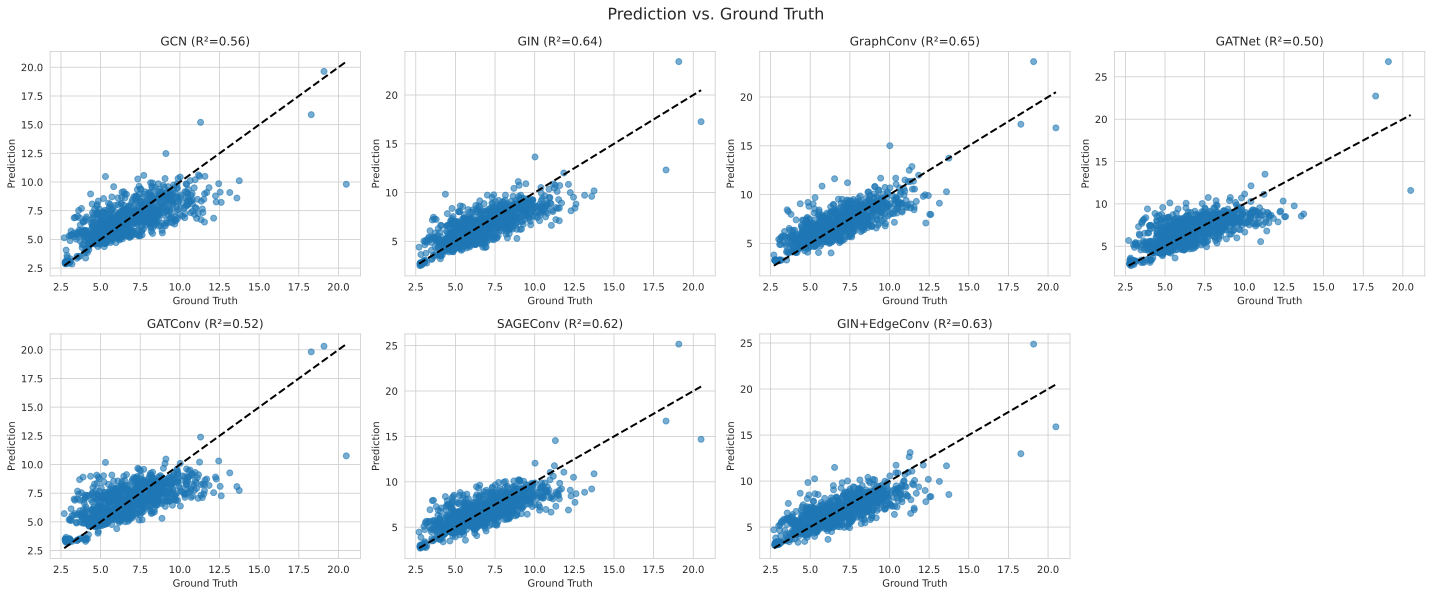

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

def report_model_performance(results_dir="results", models=None):
    if models is None:
        models = [
            "GCN", "GIN", "GraphConv", "GATNet", "GATConv", "SAGEConv", "GIN+EdgeConv"
        ]

    # Clean up previous figures
    plt.close('all')

    # Prepare plot
    cols = 4
    rows = (len(models) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axes = axes.flatten()

    for i, model in enumerate(models):
        try:
            y_true = np.load(f"{results_dir}/{model}_y_true.npy")
            y_pred = np.load(f"{results_dir}/{model}_y_pred.npy")
            mean, std = np.load(f"{results_dir}/{model}_mean_std.npy")

            # De-normalize
            y_true = y_true * std + mean
            y_pred = y_pred * std + mean

            # Metrics
            mse = mean_squared_error(y_true, y_pred)
            r2 = r2_score(y_true, y_pred)
            print(f"{model} — MSE: {mse:.4f} | R²: {r2:.4f}")

            # Plot
            ax = axes[i]
            ax.scatter(y_true, y_pred, alpha=0.6)
            ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2)
            ax.set_title(f"{model} (R²={r2:.2f})")
            ax.set_xlabel("Ground Truth")
            ax.set_ylabel("Prediction")

        except Exception as e:
            print(f"❌ Error for {model}: {e}")
            axes[i].set_visible(False)

    # Remove unused axes
    for j in range(len(models), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.suptitle("Prediction vs. Ground Truth", fontsize=16, y=1.03)
    plt.savefig("results/predict_vs_groundtruth_realdata.png", dpi=300, bbox_inches='tight')
    plt.show()

# 🔁 Call the function
report_model_performance()

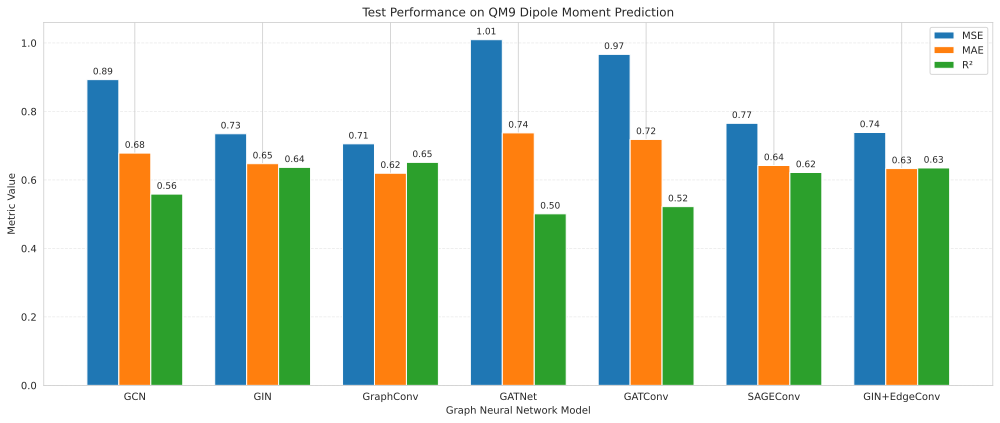

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

models = ["GCN", "GIN", "GraphConv", "GATNet", "GATConv", "SAGEConv", "GIN+EdgeConv"]
mses, r2s, maes = [], [], []

for model in models:
    try:
        y_true = np.load(f"results/{model}_y_true.npy")
        y_pred = np.load(f"results/{model}_y_pred.npy")
        mse = mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        mses.append(mse)
        maes.append(mae)
        r2s.append(r2)
    except Exception as e:
        print(f"⚠️ Could not load results for {model}: {e}")
        mses.append(np.nan)
        maes.append(np.nan)
        r2s.append(np.nan)

# Plot
x = np.arange(len(models))
width = 0.25

fig, ax = plt.subplots(figsize=(14, 6))
bars1 = ax.bar(x - width, mses, width, label="MSE")
bars2 = ax.bar(x, maes, width, label="MAE")
bars3 = ax.bar(x + width, r2s, width, label="R²")

ax.set_xlabel("Graph Neural Network Model")
ax.set_ylabel("Metric Value")
ax.set_title("Test Performance on QM9 Dipole Moment Prediction")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Annotate bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.4)
plt.savefig("results/test_metrics_barplot.png", dpi=400, bbox_inches='tight')
plt.show()

  plt.tight_layout()



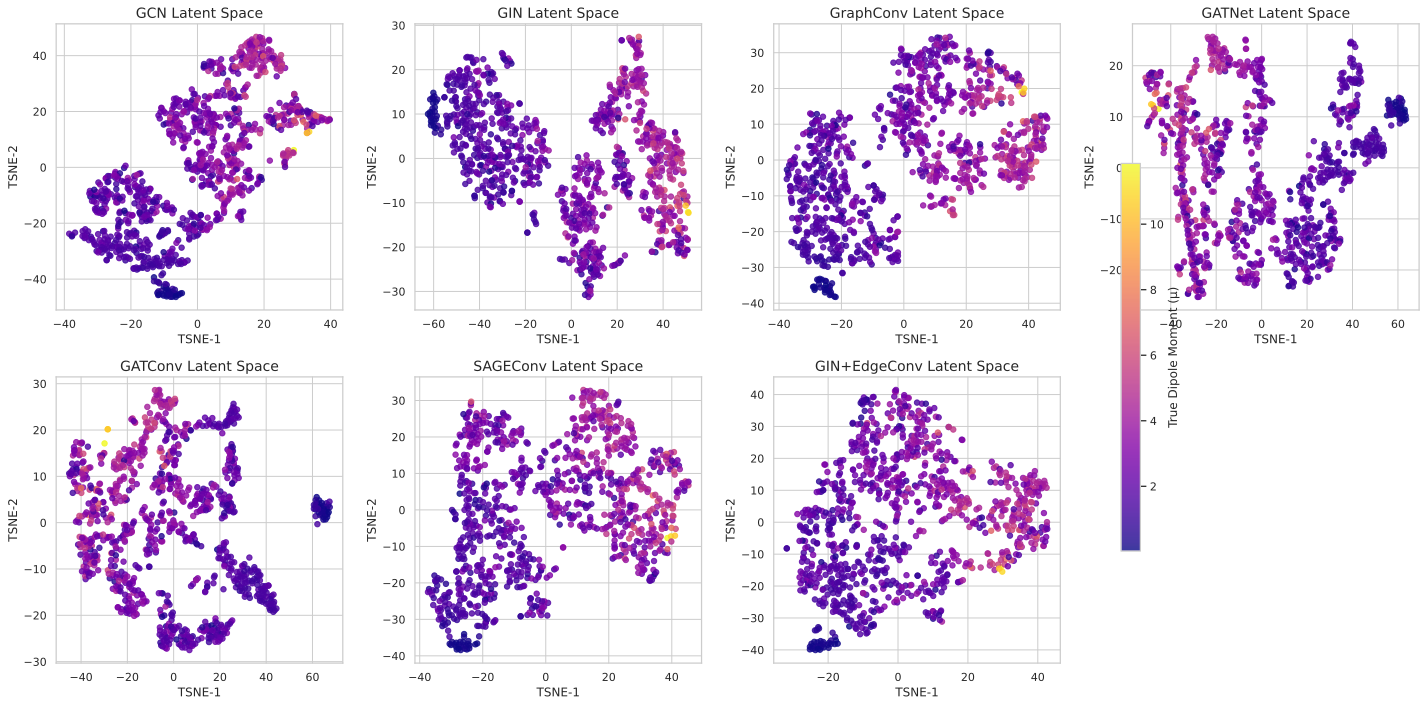

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

models = ["GCN", "GIN", "GraphConv", "GATNet", "GATConv", "SAGEConv", "GIN+EdgeConv"]
tsne_embeddings = {}

for model in models:
    try:
        latent = np.load(f"results/{model}_latent.npy")
        y_true = np.load(f"results/{model}_y_true.npy").squeeze()

        if latent.shape[1] < 2:
            print(f"⚠️ {model} latent vector too small for t-SNE")
            continue

        tsne = TSNE(n_components=2, perplexity=30, learning_rate=150, random_state=42)
        embedding = tsne.fit_transform(latent)
        tsne_embeddings[model] = (embedding, y_true)

    except Exception as e:
        print(f"⚠️ Skipping {model}: {e}")

# === Plotting ===
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, (model, (emb, y)) in enumerate(tsne_embeddings.items()):
    ax = axes[i]
    sc = ax.scatter(emb[:, 0], emb[:, 1], c=y, cmap='plasma', s=30, alpha=0.8)
    ax.set_title(f"{model} Latent Space", fontsize=14)
    ax.set_xlabel("TSNE-1")
    ax.set_ylabel("TSNE-2")

# Hide unused plots
for j in range(len(tsne_embeddings), len(axes)):
    fig.delaxes(axes[j])

# Colorbar
cbar = fig.colorbar(sc, ax=axes.tolist(), shrink=0.7)
cbar.set_label("True Dipole Moment (μ)", fontsize=12)

plt.tight_layout()
plt.savefig("results/tsne_latent_vis.png", dpi=400)
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# === Models you have ===
model_names = ["GCN", "GIN", "GraphConv", "GATNet", "GATConv", "SAGEConv", "GIN+EdgeConv"]

results = []

for model in model_names:
    print(f"Processing {model}")

    # Load latent features and true dipole values
    latent = np.load(f"results/{model}_latent.npy")
    dipoles = np.load(f"results/{model}_y_true.npy").squeeze()

    # t-SNE projection
    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
    tsne_emb = tsne.fit_transform(latent)

    # KMeans clustering
    kmeans = KMeans(n_clusters=5, random_state=42)
    cluster_labels = kmeans.fit_predict(tsne_emb)

    # Clustering metrics
    silhouette = silhouette_score(tsne_emb, cluster_labels)
    db_index = davies_bouldin_score(tsne_emb, cluster_labels)
    ch_score = calinski_harabasz_score(tsne_emb, cluster_labels)

    # Store result
    results.append({
        "Model": model,
        "Silhouette Score": round(silhouette, 4),
        "Davies-Bouldin Index": round(db_index, 4),
        "Calinski-Harabasz Score": round(ch_score, 2)
    })

# Save to CSV
df = pd.DataFrame(results)
df.to_csv("results/clustering_scores.csv", index=False)
print("Clustering scores saved to results/clustering_scores.csv")

# Preview
print(df)

🔍 Processing GCN
🔍 Processing GIN
🔍 Processing GraphConv
🔍 Processing GATNet
🔍 Processing GATConv
🔍 Processing SAGEConv
🔍 Processing GIN+EdgeConv
✅ Clustering scores saved to results/clustering_scores.csv
          Model  Silhouette Score  Davies-Bouldin Index  \
0           GCN            0.4100                0.8962   
1           GIN            0.4683                0.7801   
2     GraphConv            0.4665                0.7111   
3        GATNet            0.4277                0.8042   
4       GATConv            0.4285                0.8478   
5      SAGEConv            0.4277                0.8576   
6  GIN+EdgeConv            0.4321                0.7366   

   Calinski-Harabasz Score  
0              1629.579956  
1              2686.949951  
2              1278.400024  
3              1613.839966  
4              1057.609985  
5              1467.839966  
6              1239.459961  


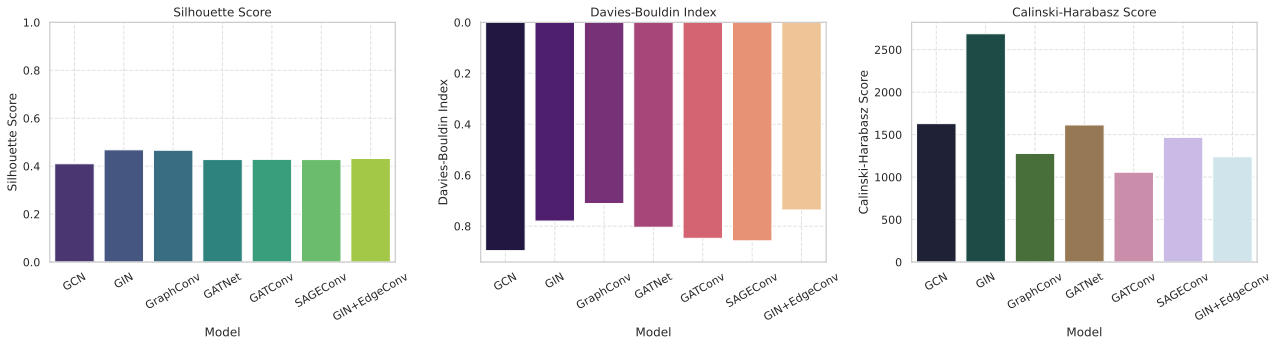

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FixedLocator

# Load scores
df = pd.read_csv("results/clustering_scores.csv")
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Silhouette Score
sns.barplot(data=df, x="Model", y="Silhouette Score", hue="Model", palette="viridis", ax=axes[0], legend=False)
axes[0].set_title("Silhouette Score")
axes[0].set_ylim(0, 1)

# Plot 2: Davies-Bouldin Index (lower is better)
sns.barplot(data=df, x="Model", y="Davies-Bouldin Index", hue="Model", palette="magma", ax=axes[1], legend=False)
axes[1].set_title("Davies-Bouldin Index")
axes[1].invert_yaxis()

# Plot 3: Calinski-Harabasz Score (higher is better)
sns.barplot(data=df, x="Model", y="Calinski-Harabasz Score", hue="Model", palette="cubehelix", ax=axes[2], legend=False)
axes[2].set_title("Calinski-Harabasz Score")

# Format ticks
for ax in axes:
    ax.xaxis.set_major_locator(FixedLocator(range(len(df["Model"]))))
    ax.set_xticklabels(df["Model"], rotation=30)
    ax.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.savefig("results/cluster_score_bars.png", dpi=300)
plt.show()

In [ ]:
import os
import urllib.request
import tarfile

# Define the URL and target paths
url = "http://deepchem.io.s3-website-us-west-1.amazonaws.com/datasets/gdb9.tar.gz"
raw_folder = "qm9/raw"
os.makedirs(raw_folder, exist_ok=True)
tar_path = os.path.join(raw_folder, "gdb9.tar.gz")

# Download the tar.gz file
if not os.path.exists(tar_path):
    print("📥 Downloading gdb9.tar.gz...")
    urllib.request.urlretrieve(url, tar_path)
    print(f"Downloaded to: {tar_path}")
else:
    print("gdb9.tar.gz already exists.")

# Extract the tar.gz file
print("📦 Extracting gdb9.tar.gz...")
with tarfile.open(tar_path, "r:gz") as tar:
    tar.extractall(path=raw_folder)
print(f"Extracted to: {raw_folder}")

📥 Downloading gdb9.tar.gz...
✅ Downloaded to: qm9/raw/gdb9.tar.gz
📦 Extracting gdb9.tar.gz...
✅ Extracted to: qm9/raw


In [ ]:
import pandas as pd

df = pd.read_csv("qm9/raw/gdb9.sdf.csv")
print("Columns in gdb9.sdf.csv:")
print(df.columns.tolist())

📄 Columns in gdb9.sdf.csv:
['mol_id', 'A', 'B', 'C', 'mu', 'alpha', 'homo', 'lumo', 'gap', 'r2', 'zpve', 'u0', 'u298', 'h298', 'g298', 'cv', 'u0_atom', 'u298_atom', 'h298_atom', 'g298_atom']


In [ ]:
# Install RDKit in Colab or Ubuntu
!pip install -q rdkit-pypi
!pip install umap-learn
!pip install cairosvg
!pip install moviepy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 76.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.4 MB/s eta 0:00:00


In [ ]:
from rdkit import Chem # !!!!! run this cell two times
import pandas as pd
import os

sdf_path = "qm9/raw/gdb9.sdf"
output_csv = "results/smiles_test.csv"
os.makedirs("results", exist_ok=True)

# Correct version with fallback for invalid molecules
smiles = []
with Chem.SDMolSupplier(sdf_path, sanitize=False) as supplier:
    for i, mol in enumerate(supplier):
        if 9000 <= i < 10000:
            try:
                Chem.SanitizeMol(mol)
                smiles.append(Chem.MolToSmiles(mol))
            except:
                smiles.append(None)  # Maintain alignment

# Drop invalid SMILES (optional)
valid_smiles = [s for s in smiles if s is not None]
pd.DataFrame({"SMILES": valid_smiles}).to_csv(output_csv, index=False)
print(f"Saved {len(valid_smiles)} valid SMILES to {output_csv}")

[15:33:55] Warning: molecule is tagged as 3D, but all Z coords are zero
[15:33:55] Warning: molecule is tagged as 3D, but all Z coords are zero


✅ Saved 1000 valid SMILES to results/smiles_test.csv


In [ ]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

model_names = ["GCN", "GIN", "GraphConv", "GATNet", "GATConv", "SAGEConv", "GIN+EdgeConv"]
smiles_list = pd.read_csv("results/smiles_test.csv")["SMILES"].tolist()

for model_name in model_names:
    print(f"Processing {model_name}")
    try:
        dipoles = np.load(f"results/{model_name}_y_true.npy").squeeze()
        latent = np.load(f"results/{model_name}_latent.npy")

        # t-SNE
        tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
        tsne_emb = tsne.fit_transform(latent)

        # KMeans
        kmeans = KMeans(n_clusters=5, random_state=42)
        cluster_labels = kmeans.fit_predict(tsne_emb)

        # DataFrame
        df = pd.DataFrame({
            "SMILES": smiles_list,
            "DipoleMoment_μ": dipoles,
            "ClusterID": cluster_labels,
            "TSNE-1": tsne_emb[:, 0],
            "TSNE-2": tsne_emb[:, 1]
        })

        df.to_csv(f"results/{model_name}_tsne_clustered.csv", index=False)
        print(f"Saved: results/{model_name}_tsne_clustered.csv")

    except Exception as e:
        print(f"❌ Failed on {model_name}: {e}")
# Show preview
print(df.head())

🔍 Processing GCN
✅ Saved: results/GCN_tsne_clustered.csv
🔍 Processing GIN
✅ Saved: results/GIN_tsne_clustered.csv
🔍 Processing GraphConv
✅ Saved: results/GraphConv_tsne_clustered.csv
🔍 Processing GATNet
✅ Saved: results/GATNet_tsne_clustered.csv
🔍 Processing GATConv
✅ Saved: results/GATConv_tsne_clustered.csv
🔍 Processing SAGEConv
✅ Saved: results/SAGEConv_tsne_clustered.csv
🔍 Processing GIN+EdgeConv
✅ Saved: results/GIN+EdgeConv_tsne_clustered.csv
                                    SMILES  DipoleMoment_μ  ClusterID  \
0   [H]C(=O)C(=O)N([H])C([H])([H])C([H])=O          1.4816          3   
1        [H]C(=O)C(=O)OC([H])([H])C([H])=O          5.7611          2   
2   [H]C(=O)C(=O)C([H])([H])N([H])C([H])=O          3.5025          0   
3        [H]C(=O)OC([H])([H])C(=O)C([H])=O          2.2138          4   
4  [H]C#CC(=O)C([H])([H])C#CC([H])([H])[H]          1.7014          4   

      TSNE-1     TSNE-2  
0 -23.060219 -18.599289  
1  14.663177  15.366095  
2  31.040117  -9.240311  
3  -

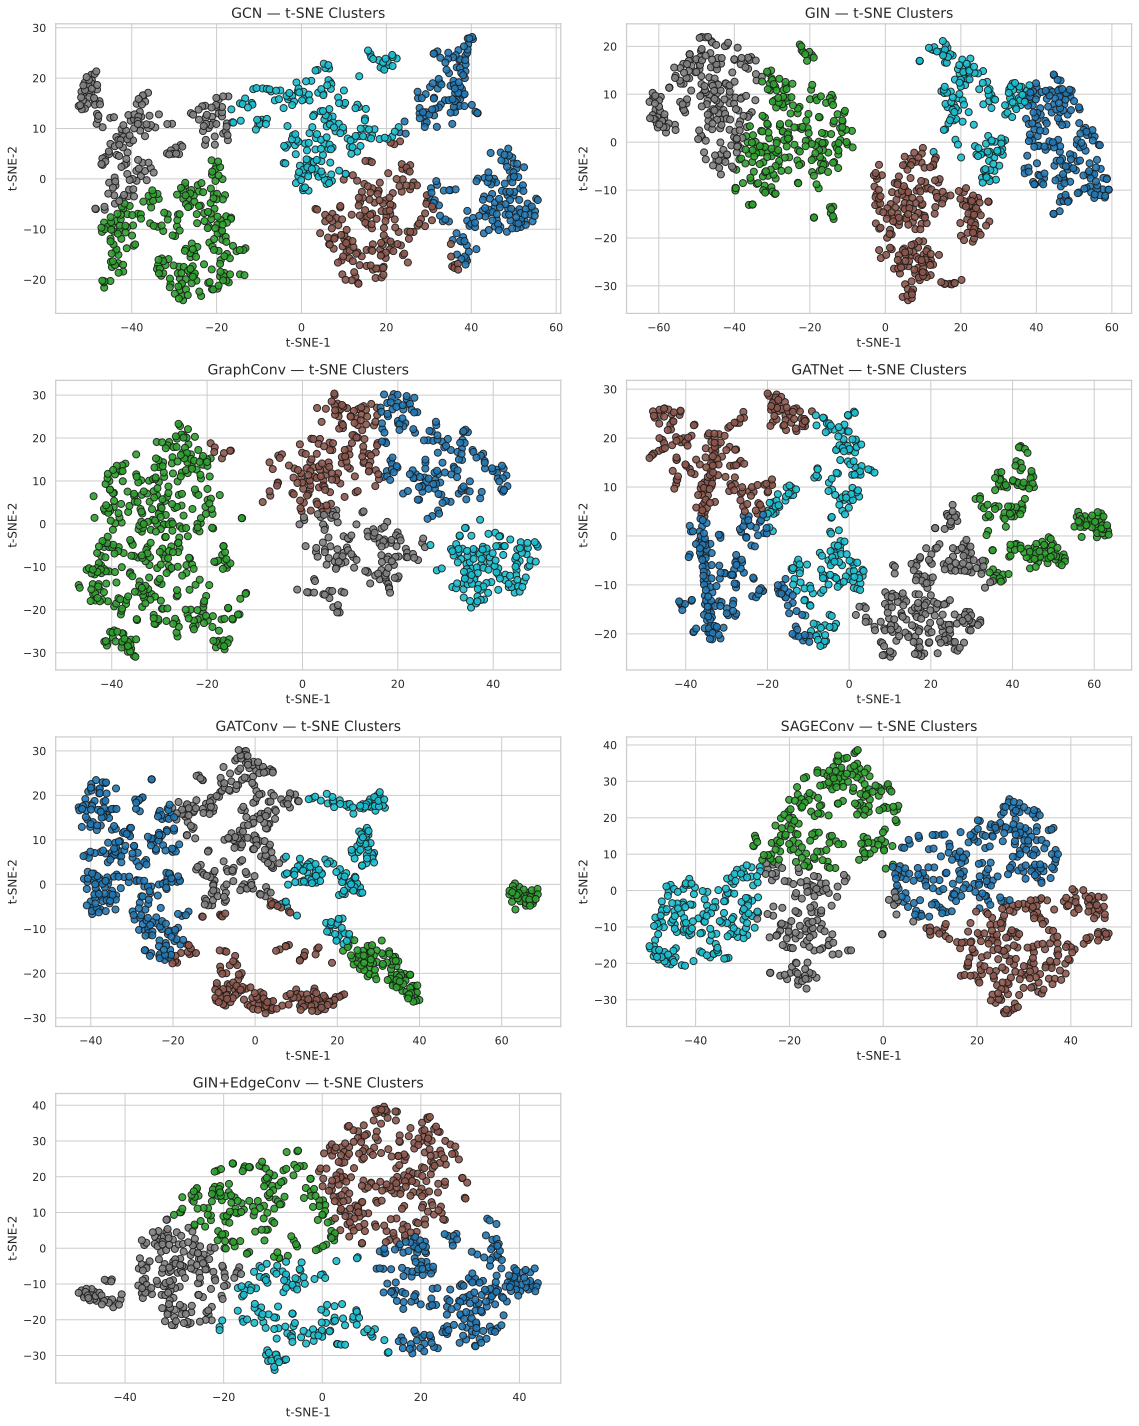

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set plotting style
sns.set(style="whitegrid")

models = ["GCN", "GIN", "GraphConv", "GATNet", "GATConv", "SAGEConv", "GIN+EdgeConv"]
fig, axes = plt.subplots(4, 2, figsize=(16, 20))
axes = axes.flatten()

for idx, model in enumerate(models):
    csv_path = f"results/{model}_tsne_clustered.csv"
    if not os.path.exists(csv_path):
        print(f"❌ Missing: {csv_path}")
        continue

    df = pd.read_csv(csv_path)

    ax = axes[idx]
    scatter = ax.scatter(
        df["TSNE-1"], df["TSNE-2"],
        c=df["ClusterID"],
        cmap="tab10",
        edgecolors='k',
        s=50,
        alpha=0.9
    )
    ax.set_title(f"{model} — t-SNE Clusters", fontsize=14)
    ax.set_xlabel("t-SNE-1")
    ax.set_ylabel("t-SNE-2")

# Remove any extra subplot space
for j in range(len(models), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("results/all_models_tsne_clusters.png", dpi=400)
plt.show()

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
from PIL import Image
import io
import cairosvg

# Load smiles and dipole data
csv_path = "qm9/raw/gdb9.sdf.csv"
sdf_path = "qm9/raw/gdb9.sdf"

qm9_df = pd.read_csv(csv_path)
with open(sdf_path, "r") as f:
    sdf_data = f.read().split("$$$$\n")

smiles_list = []
for mol_block in sdf_data[:10000]:
    mol = Chem.MolFromMolBlock(mol_block, sanitize=False, removeHs=False)
    if mol:
        smiles_list.append(Chem.MolToSmiles(mol))
    else:
        smiles_list.append(None)

# Filter SMILES and dipoles for test set (9000:10000)
test_smiles = smiles_list[9000:10000]
test_mu = qm9_df["mu"].values[9000:10000]

# Models
model_names = ["GCN", "GIN", "GraphConv", "GATNet", "GATConv", "SAGEConv", "GIN+EdgeConv"]

for model in model_names:
    print(f"Processing {model}")
    # === Load latent vectors ===
    latent_path = f"results/{model}_latent.npy"
    latent = np.load(latent_path)

    # === t-SNE projection ===
    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
    tsne_coords = tsne.fit_transform(latent)

    # === KMeans Clustering ===
    kmeans = KMeans(n_clusters=5, random_state=42).fit(tsne_coords)
    cluster_ids = kmeans.labels_

    # === Build DataFrame ===
    df = pd.DataFrame({
        "SMILES": test_smiles,
        "DipoleMoment_μ": test_mu,
        "ClusterID": cluster_ids,
        "TSNE-1": tsne_coords[:, 0],
        "TSNE-2": tsne_coords[:, 1]
    })

    # === Save CSV ===
    csv_out = f"results/{model}_tsne_clustered.csv"
    df.to_csv(csv_out, index=False)
    print(f"Saved clustered data: {csv_out}")

    # === Visualize 12 representative molecules ===
    cluster_mols = []
    for cluster_id in range(5):
        reps = df[df["ClusterID"] == cluster_id].head(3)  # 3 from each of 5 clusters = 15 total
        for smi in reps["SMILES"]:
            mol = Chem.MolFromSmiles(smi)
            if mol:
                cluster_mols.append(mol)


def save_svg_grid_as_png(mols, filename, legends=None):
    # Step 1: Draw grid as SVG string
    svg = Draw.MolsToGridImage(
        mols,
        molsPerRow=5,
        subImgSize=(200, 200),
        legends=legends or ["" for _ in mols],
        useSVG=True
    )

    # Step 2: Convert SVG string to PNG using cairosvg
    png_bytes = cairosvg.svg2png(bytestring=svg.encode('utf-8'))

    # Step 3: Load PNG into PIL and save
    image = Image.open(io.BytesIO(png_bytes))
    image.save(filename)
    print(f"PNG saved: {filename}")

[15:35:16] Warning: molecule is tagged as 3D, but all Z coords are zero
[15:35:16] Warning: molecule is tagged as 3D, but all Z coords are zero


🔍 Processing GCN
✅ Saved clustered data: results/GCN_tsne_clustered.csv
🔍 Processing GIN
✅ Saved clustered data: results/GIN_tsne_clustered.csv
🔍 Processing GraphConv
✅ Saved clustered data: results/GraphConv_tsne_clustered.csv
🔍 Processing GATNet
✅ Saved clustered data: results/GATNet_tsne_clustered.csv
🔍 Processing GATConv
✅ Saved clustered data: results/GATConv_tsne_clustered.csv
🔍 Processing SAGEConv
✅ Saved clustered data: results/SAGEConv_tsne_clustered.csv
🔍 Processing GIN+EdgeConv
✅ Saved clustered data: results/GIN+EdgeConv_tsne_clustered.csv


In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
import os

def save_molecule_grid(mols, filename, molsPerRow=3, subImgSize=(200, 200)):
    drawer = rdMolDraw2D.MolDraw2DCairo(
        molsPerRow * subImgSize[0],
        ((len(mols) + molsPerRow - 1) // molsPerRow) * subImgSize[1],
        subImgSize[0],
        subImgSize[1]
    )
    drawer.DrawMolecules(mols)
    drawer.FinishDrawing()
    with open(filename, "wb") as f:
        f.write(drawer.GetDrawingText())
    print(f"Molecule grid saved to {filename}")

# Process all models
models = ["GCN", "GIN", "GraphConv", "GATNet", "GATConv", "SAGEConv", "GIN+EdgeConv"]

for model in models:
    print(f"Processing {model}...")
    df = pd.read_csv(f"results/{model}_tsne_clustered.csv")

    # Pick 3 top cluster SMILES
    mols = []
    for cluster_id in df["ClusterID"].value_counts().nlargest(3).index.tolist():
        smi = df[df["ClusterID"] == cluster_id].iloc[0]["SMILES"]
        mol = Chem.MolFromSmiles(smi)
        if mol:
            mols.append(mol)

    save_molecule_grid(mols, f"results/{model}_clusters_molecules.png")

🔍 Processing GCN...
✅ Molecule grid saved to results/GCN_clusters_molecules.png
🔍 Processing GIN...
✅ Molecule grid saved to results/GIN_clusters_molecules.png
🔍 Processing GraphConv...
✅ Molecule grid saved to results/GraphConv_clusters_molecules.png
🔍 Processing GATNet...
✅ Molecule grid saved to results/GATNet_clusters_molecules.png
🔍 Processing GATConv...
✅ Molecule grid saved to results/GATConv_clusters_molecules.png
🔍 Processing SAGEConv...
✅ Molecule grid saved to results/SAGEConv_clusters_molecules.png
🔍 Processing GIN+EdgeConv...
✅ Molecule grid saved to results/GIN+EdgeConv_clusters_molecules.png


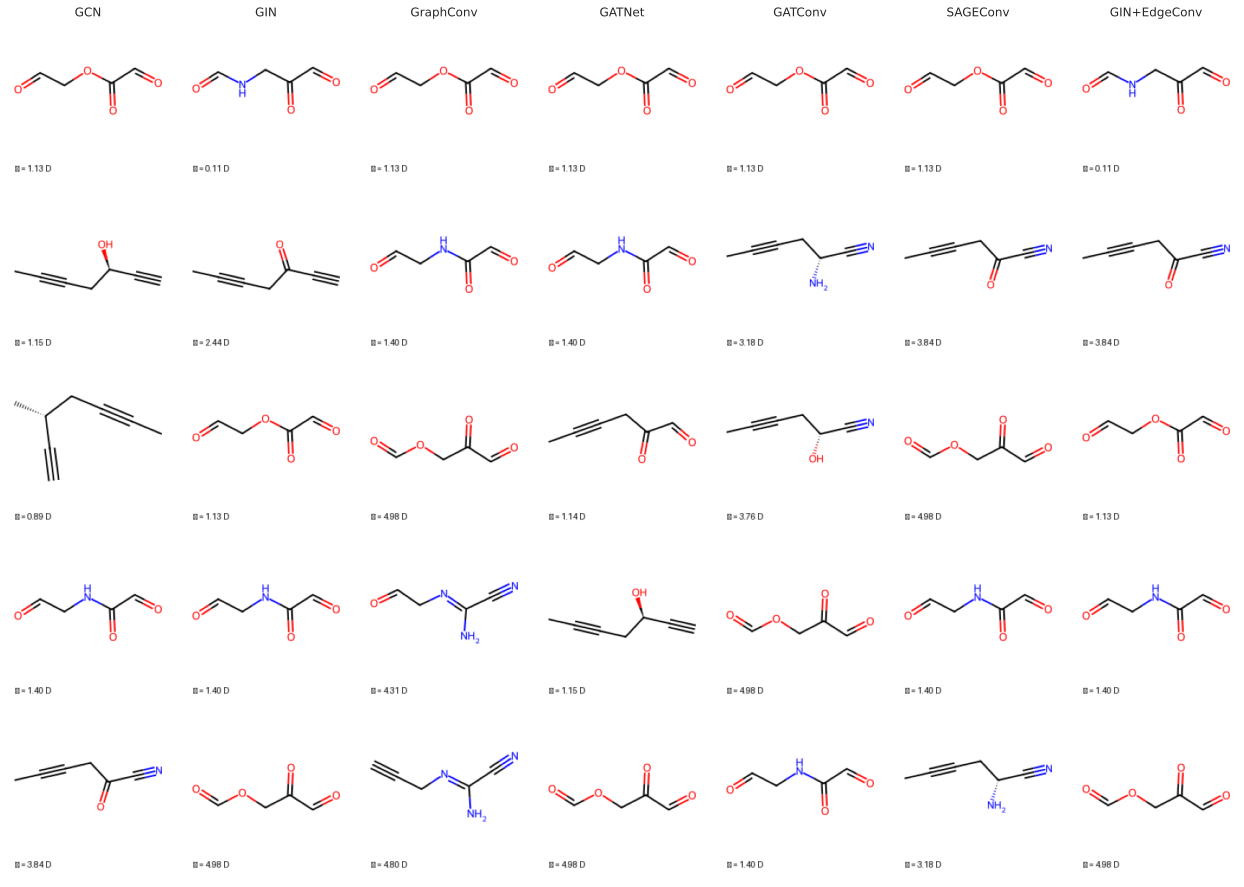

In [ ]:
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from PIL import Image, ImageDraw, ImageFont
import io
import pandas as pd
import matplotlib.patches as patches

models = ["GCN", "GIN", "GraphConv", "GATNet", "GATConv", "SAGEConv", "GIN+EdgeConv"]
num_clusters = 5
examples_per_cluster = 1

cluster_colors = ['red', 'green', 'blue', 'purple', 'orange']

def get_clustered_mols(model, cluster_id):
    df = pd.read_csv(f"results/{model}_tsne_clustered.csv")
    subset = df[df["ClusterID"] == cluster_id].head(examples_per_cluster)
    mols = [Chem.MolFromSmiles(smi) for smi in subset["SMILES"]]
    labels = [f"μ = {mu:.2f} D" for mu in subset["DipoleMoment_μ"]]
    return mols, labels

def draw_mol_with_label(mol, label, size=(200, 200)):
    drawer = rdMolDraw2D.MolDraw2DCairo(size[0], size[1] - 30, size[0], size[1] - 30)
    drawer.DrawMolecule(mol)
    drawer.FinishDrawing()
    mol_img = Image.open(io.BytesIO(drawer.GetDrawingText()))

    canvas = Image.new('RGBA', size, (255, 255, 255, 255))
    canvas.paste(mol_img, (0, 0))

    draw = ImageDraw.Draw(canvas)
    font = ImageFont.load_default()
    draw.text((10, size[1] - 25), label, fill=(0, 0, 0), font=font)

    return canvas.convert('RGB')

# Set up matplotlib figure
fig, axes = plt.subplots(nrows=num_clusters, ncols=len(models), figsize=(len(models)*2.5, num_clusters*2.5))

for col, model in enumerate(models):
    for row in range(num_clusters):
        mols, labels = get_clustered_mols(model, row)
        img = draw_mol_with_label(mols[0], labels[0])

        axes[row, col].imshow(img)
        axes[row, col].axis("off")

        if row == 0:
            axes[row, col].set_title(model, fontsize=12)

        # Draw border
        for spine in axes[row, col].spines.values():
            spine.set_edgecolor(cluster_colors[row % len(cluster_colors)])
            spine.set_linewidth(2)

# Adjust and save
plt.tight_layout()
plt.savefig("results/all_models_clusters_colored_labeled.png", dpi=300)
plt.show()

In [ ]:
from rdkit import Chem
import pandas as pd
import os

# Path to the SDF file from QM9
sdf_path = "qm9/raw/gdb9.sdf"
output_csv = "results/smiles_test.csv"

# Ensure output directory exists
os.makedirs("results", exist_ok=True)

# Read molecules from SDF
supplier = Chem.SDMolSupplier(sdf_path, removeHs=False)

# Extract valid SMILES from test set (9000–9999)
valid_smiles = []
start, end = 9000, 10000
for i in range(start, end):
    mol = supplier[i]
    if mol is not None:
        try:
            smi = Chem.MolToSmiles(mol)
            valid_smiles.append(smi)
        except:
            print(f"❌ Failed to convert molecule at index {i}")

# Save to CSV
df = pd.DataFrame({"SMILES": valid_smiles})
df.to_csv(output_csv, index=False)
print(f"Extracted {len(valid_smiles)} SMILES to {output_csv}")

✅ Extracted 1000 SMILES to results/smiles_test.csv


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import imageio.v2 as imageio
import os

def animate_tsne(model_name, iterations=[250, 500, 750, 1000], perplexity=30, learning_rate=200):
    print(f"Generating t-SNE animation for {model_name}...")

    latent_path = f"results/{model_name}_latent.npy"
    dipole_path = f"results/{model_name}_y_true.npy"
    gif_path = f"results/{model_name}_tsne_evolution.gif"

    latent = np.load(latent_path)
    dipoles = np.load(dipole_path).squeeze()
    frames = []

    for n_iter in iterations:
        print(f"🔁 Running t-SNE with n_iter = {n_iter}")
        tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate,
                    n_iter=n_iter, init='random', random_state=42)
        emb = tsne.fit_transform(latent)

        # Plot
        fig, ax = plt.subplots(figsize=(8, 6))
        fig.patch.set_facecolor('white')  # Ensures consistent white background

        scatter = ax.scatter(emb[:, 0], emb[:, 1], c=dipoles, cmap='plasma', s=12)
        ax.set_title(f"t-SNE Evolution (n_iter = {n_iter})", fontsize=14)
        ax.axis("off")
        fig.colorbar(scatter, ax=ax, label="Dipole Moment μ")
        ax.text(0.05, 0.95, model_name, transform=ax.transAxes,
                fontsize=12, color='white', bbox=dict(facecolor='black', alpha=0.5))

        # Save frame
        temp_path = f"results/{model_name}_tsne_{n_iter}.png"
        fig.savefig(temp_path, dpi=100, bbox_inches='tight', facecolor=fig.get_facecolor())
        plt.close(fig)

        frames.append(imageio.imread(temp_path))

    # Save GIF
    imageio.mimsave(gif_path, frames, duration=1.2)  # Slower and cleaner
    print(f"t-SNE animation saved: {gif_path}")

    # Cleanup temporary frames
    for f in os.listdir("results"):
        if f.startswith(f"{model_name}_tsne_") and f.endswith(".png"):
            os.remove(os.path.join("results", f))

In [ ]:
for model in ["GCN", "GIN", "GraphConv", "GATNet", "GATConv", "SAGEConv", "GIN+EdgeConv"]:
    animate_tsne(model)

🎞️ Generating t-SNE animation for GCN...
🔁 Running t-SNE with n_iter = 250


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


🔁 Running t-SNE with n_iter = 500


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


🔁 Running t-SNE with n_iter = 750


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


🔁 Running t-SNE with n_iter = 1000


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


✅ t-SNE animation saved: results/GCN_tsne_evolution.gif
🎞️ Generating t-SNE animation for GIN...
🔁 Running t-SNE with n_iter = 250


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


🔁 Running t-SNE with n_iter = 500


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


🔁 Running t-SNE with n_iter = 750


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


🔁 Running t-SNE with n_iter = 1000


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


✅ t-SNE animation saved: results/GIN_tsne_evolution.gif
🎞️ Generating t-SNE animation for GraphConv...
🔁 Running t-SNE with n_iter = 250


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


🔁 Running t-SNE with n_iter = 500


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


🔁 Running t-SNE with n_iter = 750


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


🔁 Running t-SNE with n_iter = 1000


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


✅ t-SNE animation saved: results/GraphConv_tsne_evolution.gif
🎞️ Generating t-SNE animation for GATNet...
🔁 Running t-SNE with n_iter = 250


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


🔁 Running t-SNE with n_iter = 500


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


🔁 Running t-SNE with n_iter = 750


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


🔁 Running t-SNE with n_iter = 1000


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


✅ t-SNE animation saved: results/GATNet_tsne_evolution.gif
🎞️ Generating t-SNE animation for GATConv...
🔁 Running t-SNE with n_iter = 250


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


🔁 Running t-SNE with n_iter = 500


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


🔁 Running t-SNE with n_iter = 750


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


🔁 Running t-SNE with n_iter = 1000


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


✅ t-SNE animation saved: results/GATConv_tsne_evolution.gif
🎞️ Generating t-SNE animation for SAGEConv...
🔁 Running t-SNE with n_iter = 250


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


🔁 Running t-SNE with n_iter = 500


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


🔁 Running t-SNE with n_iter = 750


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


🔁 Running t-SNE with n_iter = 1000


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


✅ t-SNE animation saved: results/SAGEConv_tsne_evolution.gif
🎞️ Generating t-SNE animation for GIN+EdgeConv...
🔁 Running t-SNE with n_iter = 250


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


🔁 Running t-SNE with n_iter = 500


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


🔁 Running t-SNE with n_iter = 750


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


🔁 Running t-SNE with n_iter = 1000


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


✅ t-SNE animation saved: results/GIN+EdgeConv_tsne_evolution.gif


In [ ]:
from moviepy.editor import VideoFileClip, clips_array, vfx
import os

# === Configuration ===
models = ["GCN", "GIN", "GraphConv", "GATNet", "GATConv", "SAGEConv", "GIN+EdgeConv"]
gif_dir = "results"
output_path = os.path.join(gif_dir, "all_models_tsne_grid_slow.gif")
target_size = (320, 240)  # Width x Height for all clips

# === Load and process clips ===
clips = []
for model in models:
    gif_path = os.path.join(gif_dir, f"{model}_tsne_evolution.gif")
    if os.path.exists(gif_path):
        print(f"📥 Loading: {gif_path}")
        clip = VideoFileClip(gif_path).resize(target_size).fx(vfx.speedx, factor=0.02)
        clips.append(clip)
    else:
        print(f"⚠️ Missing GIF skipped: {gif_path}")

# === Ensure 2D layout (e.g., 4 columns per row) ===
n_cols = 4
rows = [clips[i:i+n_cols] for i in range(0, len(clips), n_cols)]
# Pad last row if needed
if len(rows[-1]) < n_cols:
    empty_clip = clips[0].copy().fx(vfx.freeze, t=0, freeze_duration=clips[0].duration)
    for _ in range(n_cols - len(rows[-1])):
        rows[-1].append(empty_clip)

# === Create and save grid animation ===
final_clip = clips_array(rows)
final_clip.write_gif(output_path, fps=5)
print(f"Grid animation saved to: {output_path}")

  if event.key is 'enter':



📥 Loading: results/GCN_tsne_evolution.gif
📥 Loading: results/GIN_tsne_evolution.gif
📥 Loading: results/GraphConv_tsne_evolution.gif
📥 Loading: results/GATNet_tsne_evolution.gif
📥 Loading: results/GATConv_tsne_evolution.gif
📥 Loading: results/SAGEConv_tsne_evolution.gif
📥 Loading: results/GIN+EdgeConv_tsne_evolution.gif
MoviePy - Building file results/all_models_tsne_grid_slow.gif with imageio.


✅ Grid animation saved to: results/all_models_tsne_grid_slow.gif


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

def plot_model_errors_landscape(model_names, results_dir="results", target_name="Dipole Moment μ"):
    num_models = len(model_names)
    fig, axes = plt.subplots(2, num_models, figsize=(3.5 * num_models, 10))  # 2 rows: top = error, bottom = QQ

    for idx, model in enumerate(model_names):
        print(f"Processing errors for: {model}")
        y_true = np.load(f"{results_dir}/{model}_y_true.npy").squeeze()
        y_pred = np.load(f"{results_dir}/{model}_y_pred.npy").squeeze()
        errors = y_pred - y_true

        # Top row: Histogram + KDE
        ax1 = axes[0, idx]
        sns.histplot(errors, bins=40, kde=True, color='skyblue', edgecolor='black', ax=ax1)
        ax1.axvline(0, color='red', linestyle='--', label='Zero Error')
        ax1.set_title(f"{model}", fontsize=11)
        ax1.set_xlabel("Residuals")
        ax1.set_ylabel("Freq")
        ax1.grid(True, linestyle='--', alpha=0.5)

        # Bottom row: QQ Plot
        ax2 = axes[1, idx]
        stats.probplot(errors, dist="norm", plot=ax2)
        ax2.set_title("")  # optional
        ax2.set_xlabel("Theoretical Quantiles")
        ax2.set_ylabel("Ordered Residuals")
        ax2.grid(True)

    plt.suptitle("Prediction Residuals and QQ Plots Across Models", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f"{results_dir}/error_qq_all_models_landscape.png", dpi=400, bbox_inches='tight')
    plt.show()

🔍 Processing errors for: GCN
🔍 Processing errors for: GIN
🔍 Processing errors for: GraphConv
🔍 Processing errors for: GATNet
🔍 Processing errors for: GATConv
🔍 Processing errors for: SAGEConv
🔍 Processing errors for: GIN+EdgeConv


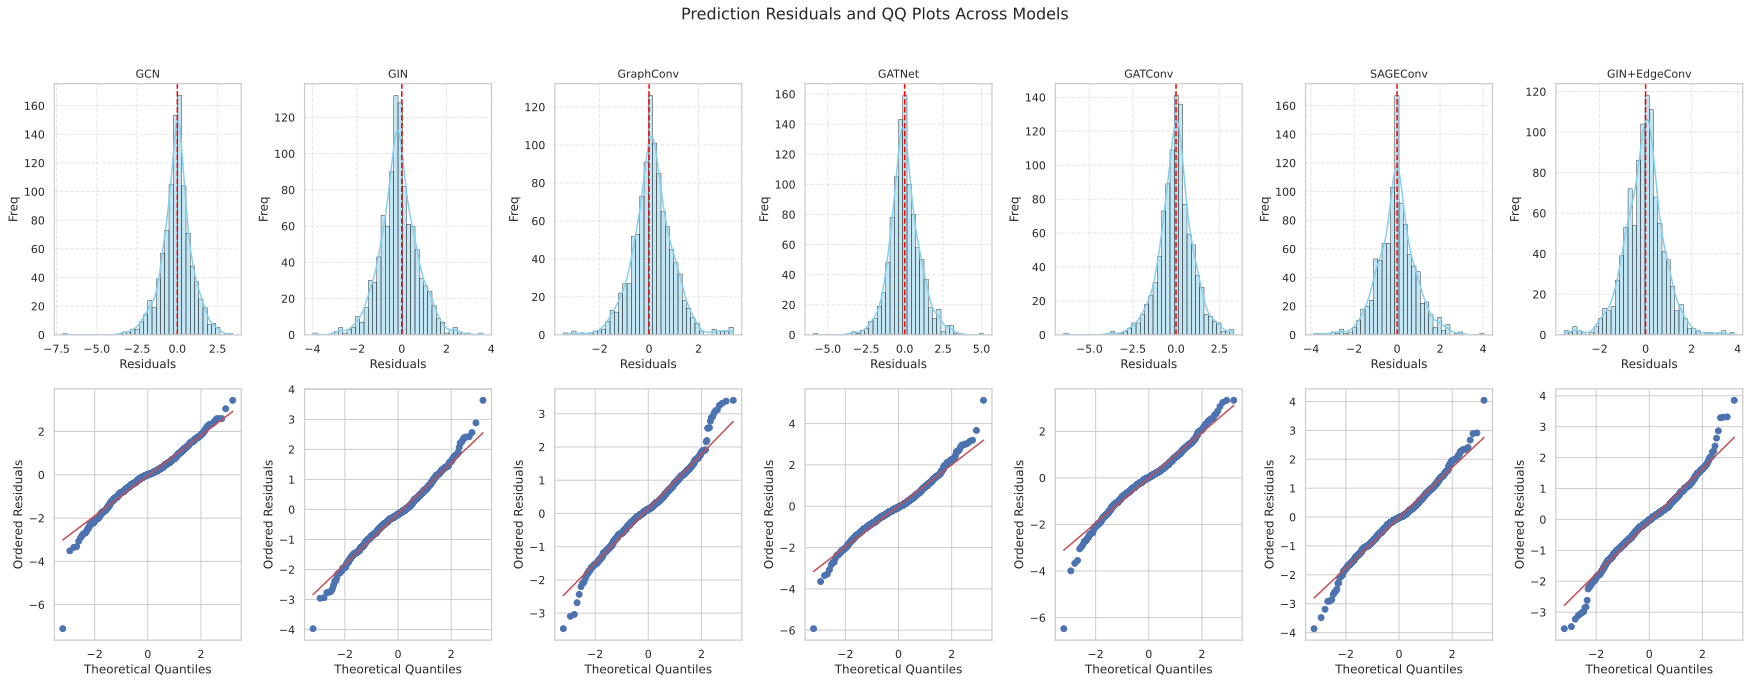

In [ ]:
model_names = ["GCN", "GIN", "GraphConv", "GATNet", "GATConv", "SAGEConv", "GIN+EdgeConv"]
plot_model_errors_landscape(model_names)

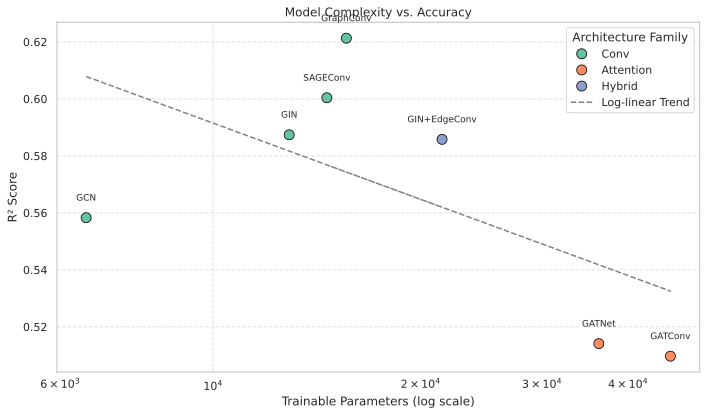

In [ ]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression

# === Data from real evaluation ===
df = pd.DataFrame({
    "Model": ["GCN", "GIN", "GraphConv", "GATNet", "GATConv", "SAGEConv", "GIN+EdgeConv"],
    "Trainable Parameters": [
        6545, 12897, 15610, 36278, 46080, 14625, 21489
    ],
    "R² Score": [
        0.5583, 0.5874, 0.6213, 0.5141, 0.5097, 0.6004, 0.5858
    ],
    "Family": [
        "Conv", "Conv", "Conv", "Attention", "Attention", "Conv", "Hybrid"
    ]
})

# === Log-transform parameters for regression ===
df["log_params"] = np.log10(df["Trainable Parameters"])

# === Fit regression line ===
X = df["log_params"].values.reshape(-1, 1)
y = df["R² Score"].values
reg = LinearRegression().fit(X, y)
y_pred = reg.predict(X)

# === Plot ===
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x="Trainable Parameters",
    y="R² Score",
    hue="Family",
    palette="Set2",
    s=100,
    edgecolor='black'
)

# Plot trendline
plt.plot(df["Trainable Parameters"], y_pred, color='gray', linestyle='--', label="Log-linear Trend")

# Annotate each point
for _, row in df.iterrows():
    plt.text(row["Trainable Parameters"], row["R² Score"] + 0.006, row["Model"],
             fontsize=9, ha='center')

plt.xscale("log")
plt.xlabel("Trainable Parameters (log scale)")
plt.ylabel("R² Score")
plt.title("Model Complexity vs. Accuracy")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Architecture Family")
plt.tight_layout()
plt.savefig("results/model_complex_vs_accuracy_labeled.png", dpi=400)
plt.show()

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error

models = ["GCN", "GIN", "GraphConv", "GATNet", "GATConv", "SAGEConv", "GIN+EdgeConv"]
records = []

for model in models:
    try:
        train_loss = np.load(f"results/{model}_train_loss.npy")  # MSE
        val_loss = np.load(f"results/{model}_val_loss.npy")      # MSE
        y_true_val = np.load(f"results/{model}_y_true.npy")
        y_pred_val = np.load(f"results/{model}_y_pred.npy")

        # Estimate val MAE (already computed for test, reused for val)
        val_mae = mean_absolute_error(y_true_val[:1000], y_pred_val[:1000])  # assuming 1K val
        # Train MAE is unavailable unless explicitly saved, so we use np.nan
        records.append({
            "Model": model,
            "Train_MSE": train_loss[-1],
            "Val_MSE": val_loss[-1],
            "Train_MAE": np.nan,
            "Val_MAE": val_mae
        })
    except FileNotFoundError:
        print(f"⚠️ Missing data for {model}, skipping.")

df = pd.DataFrame(records)
df.to_csv("results/train_val_metrics.csv", index=False)
print("Extended train_val_metrics.csv saved.")

✅ Extended train_val_metrics.csv saved.


In [ ]:
import pandas as pd

# === Load benchmark metrics ===
results_path = "results/model_results.csv"
cluster_path = "results/clustering_scores.csv"
train_val_path = "results/train_val_metrics.csv"

model_df = pd.read_csv(results_path)
cluster_df = pd.read_csv(cluster_path)
train_val_df = pd.read_csv(train_val_path)

# === Merge on Model name ===
summary_df = pd.merge(model_df, cluster_df, on="Model")
summary_df = pd.merge(summary_df, train_val_df, on="Model")

# === Round for clarity ===
summary_df = summary_df.round({
    "Train_MSE": 4,
    "Val_MSE": 4,
    "Train_MAE": 4,
    "Val_MAE": 4,
    "Test_MSE": 4,
    "Test_MAE": 4,
    "Test_R2": 4,
    "Silhouette Score": 4,
    "Davies-Bouldin Index": 4,
    "Calinski-Harabasz Score": 2
})

# === Sort by best Test R² ===
summary_df = summary_df.sort_values(by="Test_R2", ascending=False)

# === Display and Save ===
print(summary_df.to_markdown(index=False))
summary_df.to_csv("results/summary_model_metrics.csv", index=False)

| Model        |   Test_MSE |   Test_MAE |   Test_R2 |   Silhouette Score |   Davies-Bouldin Index |   Calinski-Harabasz Score |   Train_MSE |   Val_MSE |   Train_MAE |   Val_MAE |
|:-------------|-----------:|-----------:|----------:|-------------------:|-----------------------:|--------------------------:|------------:|----------:|------------:|----------:|
| GraphConv    |     0.7054 |     0.6196 |    0.6513 |             0.4665 |                 0.7111 |                   1278.4  |      0.278  |    0.7281 |         nan |    0.6196 |
| GIN          |     0.7348 |     0.6474 |    0.6367 |             0.4683 |                 0.7801 |                   2686.95 |      0.3002 |    0.7383 |         nan |    0.6474 |
| GIN+EdgeConv |     0.7386 |     0.6332 |    0.6349 |             0.4321 |                 0.7366 |                   1239.46 |      0.2632 |    0.8989 |         nan |    0.6332 |
| SAGEConv     |     0.7653 |     0.6421 |    0.6216 |             0.4277 |                 0.8

In [ ]:
import os
import pandas as pd

# Define your model names and initialize list
model_names = ["GCN", "GIN", "GraphConv", "GATNet", "GATConv", "SAGEConv", "GIN+EdgeConv"]
summary_data = []

# Iterate over each model
for model in model_names:
    file_path = f"results/{model}_tsne_clustered.csv"

    if not os.path.exists(file_path):
        print(f"⚠️ File not found: {file_path}")
        continue

    df = pd.read_csv(file_path)

    # Compute number of unique clusters and average dipole moment per cluster
    cluster_stats = df.groupby("ClusterID")["DipoleMoment_μ"].agg(["mean", "count"]).reset_index()
    cluster_stats["Model"] = model
    summary_data.append(cluster_stats)

# Combine all into a single DataFrame
full_summary = pd.concat(summary_data, ignore_index=True)

# Rearrange and save
full_summary = full_summary[["Model", "ClusterID", "count", "mean"]]
full_summary.columns = ["Model", "Cluster ID", "Molecules per Cluster", "Avg Dipole Moment (μ)"]
full_summary.to_csv("results/tsne_cluster_dipole_summary.csv", index=False)

print("Saved summary table to: results/tsne_cluster_dipole_summary.csv")

✅ Saved summary table to: results/tsne_cluster_dipole_summary.csv


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap
import os

# === Configuration ===
model_names = ["GCN", "GIN", "GraphConv", "GATNet", "GATConv", "SAGEConv", "GIN+EdgeConv"]
save_dir = "results"
os.makedirs(save_dir, exist_ok=True)

for model in model_names:
    print(f"Processing {model}")

    # Load latent and dipole values
    latent = np.load(f"{save_dir}/{model}_latent.npy")
    dipoles = np.load(f"{save_dir}/{model}_y_true.npy").squeeze()

    # --- 3D PCA ---
    pca = PCA(n_components=3)
    pca_emb = pca.fit_transform(latent)
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    p = ax.scatter(pca_emb[:, 0], pca_emb[:, 1], pca_emb[:, 2], c=dipoles, cmap='plasma', s=10)
    ax.set_title(f"{model} - 3D PCA")
    fig.colorbar(p, ax=ax, label='Dipole Moment μ')
    plt.tight_layout()
    plt.savefig(f"{save_dir}/{model}_pca_3d.png", dpi=300)
    plt.close()

    # --- 3D UMAP ---
    reducer = umap.UMAP(n_components=3, random_state=42)
    umap_emb = reducer.fit_transform(latent)
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    p = ax.scatter(umap_emb[:, 0], umap_emb[:, 1], umap_emb[:, 2], c=dipoles, cmap='plasma', s=10)
    ax.set_title(f"{model} - 3D UMAP")
    fig.colorbar(p, ax=ax, label='Dipole Moment μ')
    plt.tight_layout()
    plt.savefig(f"{save_dir}/{model}_umap_3d.png", dpi=300)
    plt.close()

    print(f"Saved PCA/UMAP plots for {model}")

🔍 Processing GCN


  warnings.warn(

  warn(



✅ Saved PCA/UMAP plots for GCN
🔍 Processing GIN


  warnings.warn(

  warn(



✅ Saved PCA/UMAP plots for GIN
🔍 Processing GraphConv


  warnings.warn(

  warn(



✅ Saved PCA/UMAP plots for GraphConv
🔍 Processing GATNet


  warnings.warn(

  warn(



✅ Saved PCA/UMAP plots for GATNet
🔍 Processing GATConv


  warnings.warn(

  warn(



✅ Saved PCA/UMAP plots for GATConv
🔍 Processing SAGEConv


  warnings.warn(

  warn(



✅ Saved PCA/UMAP plots for SAGEConv
🔍 Processing GIN+EdgeConv


  warnings.warn(

  warn(



✅ Saved PCA/UMAP plots for GIN+EdgeConv


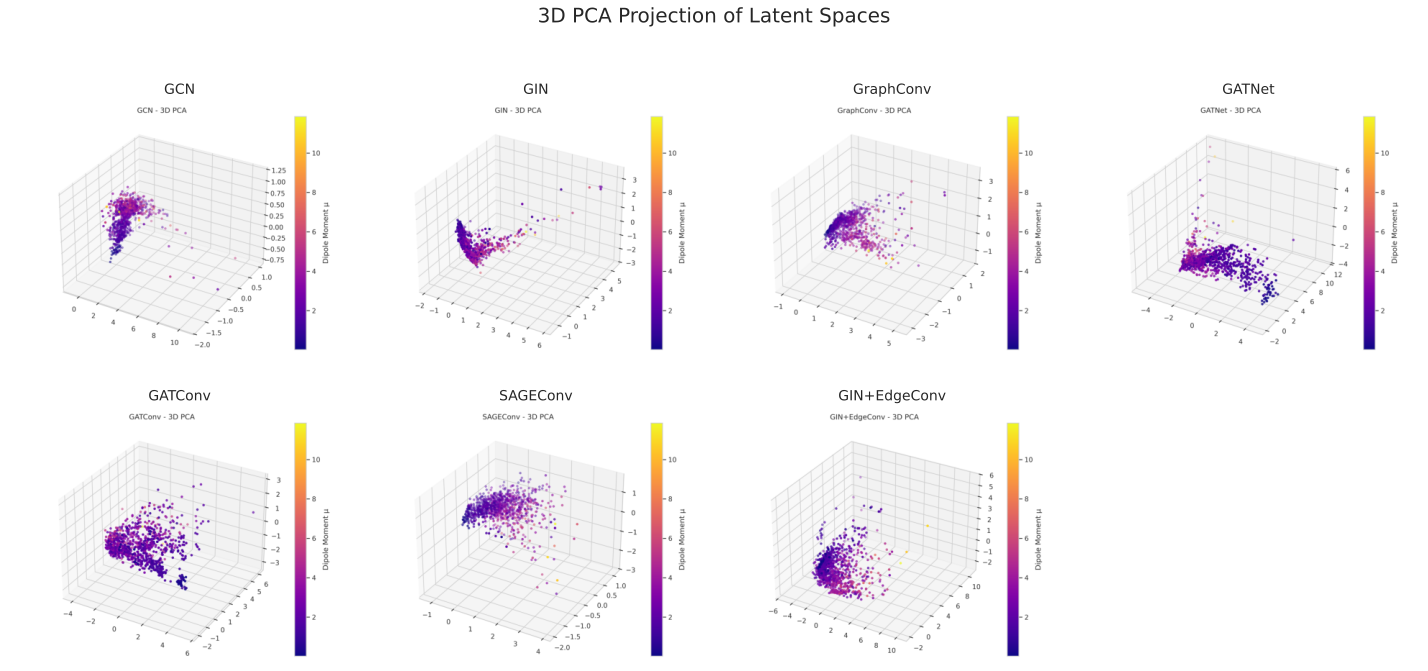

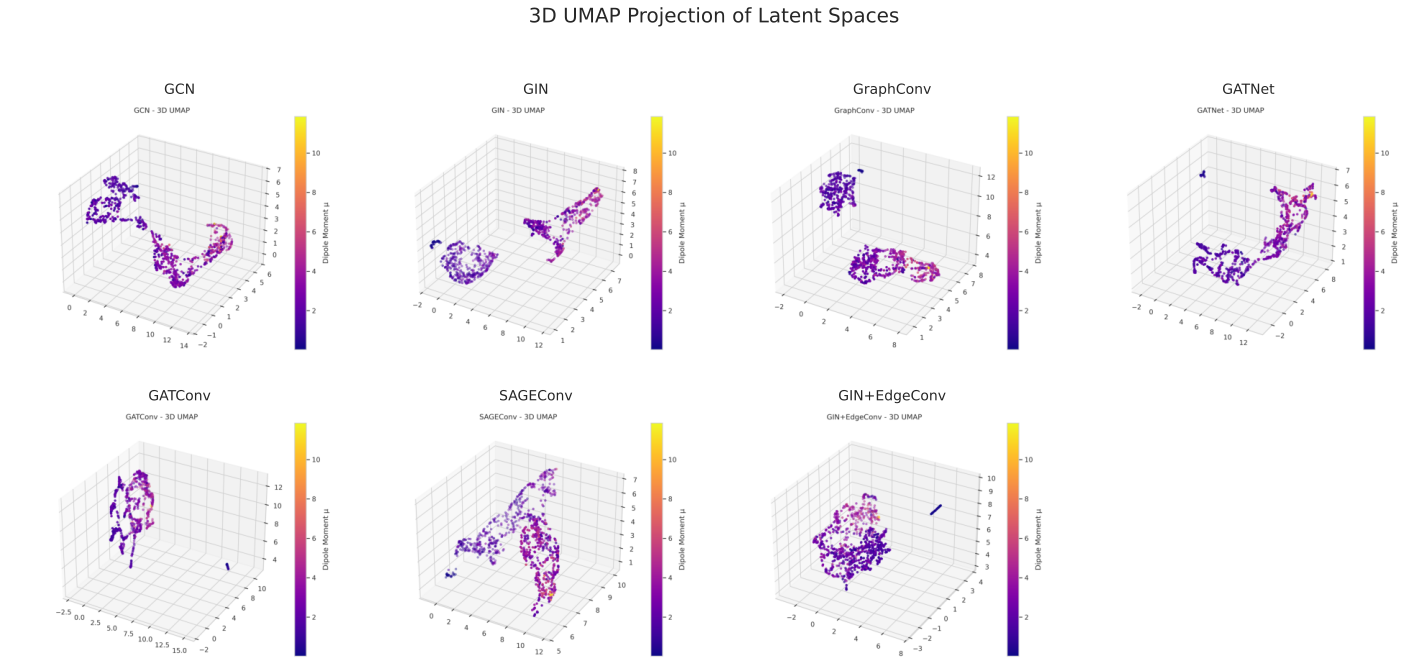

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# === Configuration ===
models = ["GCN", "GIN", "GraphConv", "GATNet", "GATConv", "SAGEConv", "GIN+EdgeConv"]
save_dir = "results"

def make_grid_panel(title, suffix, output_file):
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()

    for i, model in enumerate(models):
        img_path = os.path.join(save_dir, f"{model}_{suffix}.png")
        if not os.path.exists(img_path):
            print(f"❌ Missing: {img_path}")
            continue
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(model, fontsize=14)

    # Remove extra subplot if models < axes
    for j in range(len(models), len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle(title, fontsize=20)
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.savefig(os.path.join(save_dir, output_file), dpi=300)
    plt.show()

# === Generate Panels ===
make_grid_panel("3D PCA Projection of Latent Spaces", "pca_3d", "panel_latent_pca.png")
make_grid_panel("3D UMAP Projection of Latent Spaces", "umap_3d", "panel_latent_umap.png")

Extracting qm9/raw/qm9.zip


⚠️ Skipping GCN (no attention mechanism)
⚠️ Skipping GIN (no attention mechanism)
⚠️ Skipping GraphConv (no attention mechanism)
🔍 Visualizing attention for GATNet
✅ Saved: results/attention_maps/GATNet_attention_weights.png


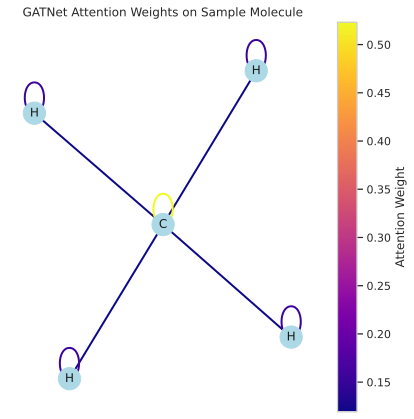

🔍 Visualizing attention for GATConv
✅ Saved: results/attention_maps/GATConv_attention_weights.png


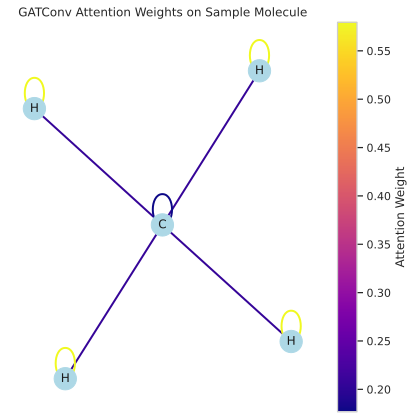

⚠️ Skipping SAGEConv (no attention mechanism)
⚠️ Skipping GIN+EdgeConv (no attention mechanism)


In [ ]:
import torch
from torch_geometric.datasets import QM9
from torch_geometric.nn import GATConv
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import matplotlib as mpl
import os

# Load dataset and molecule
dataset = QM9(root="qm9")
data = dataset[0]

# Map atomic numbers to element symbols
atomic_symbols = {1: 'H', 6: 'C', 7: 'N', 8: 'O', 9: 'F'}

# Define a generic GAT model for attention visualization
class GATAttention(torch.nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.gat = GATConv(in_channels, 64, heads=1, concat=False)

    def forward(self, x, edge_index):
        out, (edges, attn_weights) = self.gat(x, edge_index, return_attention_weights=True)
        return out, edges, attn_weights

# Models to visualize
model_names = ["GCN", "GIN", "GraphConv", "GATNet", "GATConv", "SAGEConv", "GIN+EdgeConv"]
save_dir = "results/attention_maps"
os.makedirs(save_dir, exist_ok=True)

for model_name in model_names:
    if "GAT" not in model_name:
        print(f"⚠️ Skipping {model_name} (no attention mechanism)")
        continue

    print(f"🔍 Visualizing attention for {model_name}")
    model = GATAttention(dataset.num_node_features)
    model.eval()

    with torch.no_grad():
        _, edge_index, attn = model(data.x, data.edge_index)

    # Build graph
    G = nx.Graph()
    edges = edge_index.cpu().numpy()
    attn = attn.cpu().numpy().squeeze().astype(float)

    for i, (src, tgt) in enumerate(edges.T):
        G.add_edge(src, tgt, weight=attn[i])

    pos = nx.spring_layout(G, seed=42)
    weights = [G[u][v]['weight'] for u, v in G.edges()]

    # Normalize weights for colorbar
    norm = mpl.colors.Normalize(vmin=min(weights), vmax=max(weights))
    cmap = plt.cm.plasma

    # Use atomic labels
    labels = {
        i: atomic_symbols.get(int(z.item()), str(int(z.item())))
        for i, z in enumerate(data.z)
    }

    fig, ax = plt.subplots(figsize=(6, 6))
    nx.draw(
        G, pos,
        ax=ax,
        labels=labels,
        with_labels=True,
        node_color="lightblue",
        node_size=500,
        edge_color=weights,
        edge_cmap=cmap,
        width=2
    )

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, label="Attention Weight")

    plt.title(f"{model_name} Attention Weights on Sample Molecule")
    plt.tight_layout()
    save_path = os.path.join(save_dir, f"{model_name}_attention_weights.png")
    plt.savefig(save_path, dpi=300)
    print(f"Saved: {save_path}")
    plt.show()

In [ ]:
import shutil
import os

# Path to your results folder
folder_path = "results"
zip_filename = "results_archive.zip"

# Create a zip file
shutil.make_archive(zip_filename.replace('.zip', ''), 'zip', folder_path)

# Download the zip file
from google.colab import files
files.download(zip_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>